# EIS Post-Processing - Clean up HFR & LFR
***Created by Robert Black - April 14, 2022***<br>
Small script to filter out high frequency and low frequency parts of EIS spectra for post-processing purposes
This script performs the filtering in two sections:
1. HFR: Utilizes Phase_Zwe at the minimum to determine when -Im(Z) == 0 and filters out all high frequency regions before that. Focuses only on the high frequency region as to not remove low frequency region inductances that may occur.


2. LFR: Lin-KK validation residuals are used to detect when the linearity relationships between Im(Z) and Re(Z) breakdown, and uses a defined threshold value to 'trigger' the filter to not use the data when the residuals are beyond a certain value.

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from numpy import genfromtxt
import impedance
from impedance import preprocessing
from impedance.validation import linKK
from scipy.signal import find_peaks
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
# set plotting params and data directory
datadir = 'C:/Users/Blackr/Documents/MAPs/Black_Relevent/MAPs/DRT/CO2_Electrolyzer'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

In [17]:
'''
DataCleaning for EIS Data
'''

# Data import
def EIS_Clean(root_path,test_name):
    file = f'{root_path}{test_name}.csv'
    data = genfromtxt(file, delimiter=',', skip_header=66)
    data = np.transpose(data)

    freq = data[0]
    abs_Ewe = data[12]
    abs_I = data[13]
    Phase_Zwe = data[4]
    Re_Z = data[1]
    Im_Z = -data[2]

    data = {'frequencies':freq.tolist(),'abs_Ewe':abs_Ewe.tolist(),'abs_I':abs_I.tolist(),'Phase_Zwe':Phase_Zwe.tolist()}
    abs_Z = np.divide(data['abs_Ewe'], data['abs_I'])
    # Re_Z = abs_Z * (np.cos(np.radians(data['Phase_Zwe'])))
    # Im_Z = abs_Z * (np.sin(np.radians(data['Phase_Zwe'])))
    #Convert Re_Z and Im_Z into a single complex numpy array
    Z = Re_Z + 1j*Im_Z

    #Set plotting parameters for the non-filtered data
    fig,axes = plt.subplots(1,3,figsize=(15,3.5))

    axes[0].scatter(Re_Z,-Im_Z)
    axes[0].set_xlabel(r'$Re(Z) / \Omega$')
    axes[0].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[0].set_title('Non-filtered')
    axes[1].scatter(freq,Re_Z)
    axes[1].set_xscale('log')
    axes[1].set_xlabel('freq (Hz)')
    axes[1].set_ylabel(r'$Re(Z) / \Omega$')
    axes[1].set_title('Non-filtered')
    axes[2].scatter(freq,-Im_Z)
    axes[2].set_xscale('log')
    axes[2].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[2].set_xlabel('freq (Hz)')
    axes[2].set_title('Non-filtered')
    plt.show()

    ### FILTER 1 - High Frequency Region
    ### Find index where phase_Zwe == minimum, remove all high frequency values below zero
    index, = np.where(abs(Phase_Zwe[0:20]) == abs(Phase_Zwe[0:20]).min()) #finds minimum phase value, note returns as a tuple
    mask_phase = [True]*len(Phase_Zwe)
    for i in range(len(Phase_Zwe)):
        if i < index:
            mask_phase[i] = False

    freq = freq[index[0]:]
    Z = Z[index[0]:]
    Re_Z = Re_Z[index[0]:]
    Im_Z = Im_Z[index[0]:]

    ### FILTER 2 - Low Frequency Region
    ### Lin-KK data validation to remove 'noisy' data
    ### For Lin-KK, the residuals of Re(Z) and Im(Z) are what will be used as a filter. I have found based on the data set that
    ### somewhere ~0.05% works the best
    M, mu, Z_linKK, res_real, res_imag = linKK(freq, Z, c=.5, max_M=100, fit_type='complex', add_cap=True)

    # Plot residuals of Lin-KK for visualization purposes. 
    plt.plot(freq, res_imag, label = 'delta Im')
    plt.plot(freq, res_real, label = 'delta Re')
    plt.xlabel('freq (Hz)')
    plt.ylabel('Delta %')
    plt.xscale('log')
    plt.title('Link-KK Validation')
    plt.legend()
    plt.show()

    # Need to set a threshold limit for when to filter out the noisy data of the residuals
    threshold = 0.05 # USER DEFINE!!!

    mask = [False]*(len(res_imag))
    for i in range(len(res_imag)):
        if res_imag[i] < threshold:
            mask[i] = True
        else:
            break

    freq_mask = freq[mask]
    Z_mask = Z[mask]
    Re_Z_mask = Re_Z[mask]
    Im_Z_mask = Im_Z[mask]

    #Putting into a dataframe for use with plotting and program
    values = np.array([freq,Re_Z,Im_Z])
    values_mask = np.array([freq_mask,Re_Z_mask,Im_Z_mask])
    labels = ['freq','Zreal','Zimag']
    Zdf = pd.DataFrame(values.transpose(), columns = labels)
    Zdf_mask = pd.DataFrame(values_mask.transpose(), columns = labels)

    # Plot the data to see how the filter performed
    fig,axes = plt.subplots(1,3,figsize=(15,3.5))
    axes[0].scatter(Zdf_mask['Zreal'].values,-Zdf_mask['Zimag'].values)
    axes[0].set_xlabel(r'$Re(Z) / \Omega$')
    axes[0].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[0].set_title('Filtered')
    axes[1].scatter(Zdf_mask['freq'].values,Zdf_mask['Zreal'].values)
    axes[1].set_xscale('log')
    axes[1].set_xlabel('freq (Hz)')
    axes[1].set_ylabel(r'$Re(Z) / \Omega$')
    axes[1].set_title('Filtered')
    axes[2].scatter(Zdf_mask['freq'].values,-Zdf_mask['Zimag'].values)
    axes[2].set_xscale('log')
    axes[2].set_ylabel(r'$-Im(Z) / \Omega$')
    axes[2].set_xlabel('freq (Hz)')
    axes[2].set_title('Filtered')

***Below are exmaples based on Parisa's dataset***

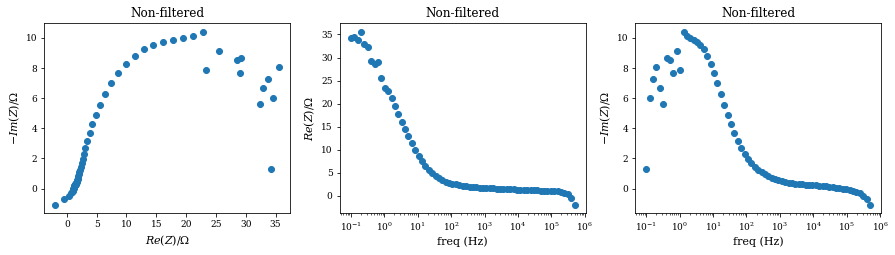

10 1.0 0.8071520620298872


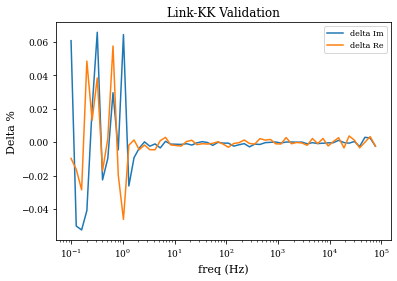

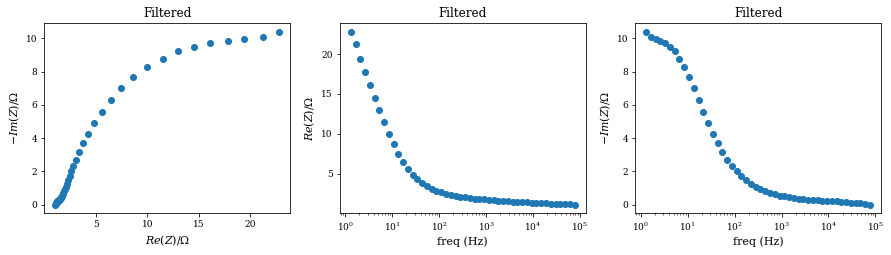

In [26]:
root_path = 'C:\\Users\\Blackr\\Documents\\MAPs\\Black_Relevent\\MAPs\\DRT\\CO2_Electrolyzer\\Parisa_Noise_April14\\'
test_name = '1-MEA#3_06_PEIS_C01'
EIS_Clean(root_path,test_name)

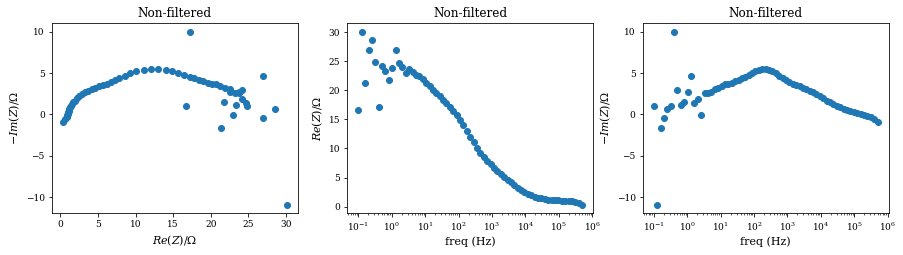

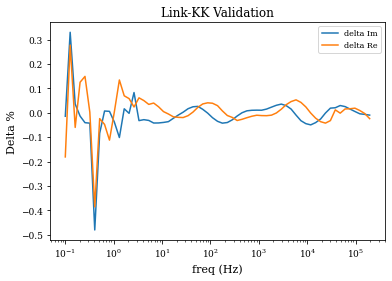

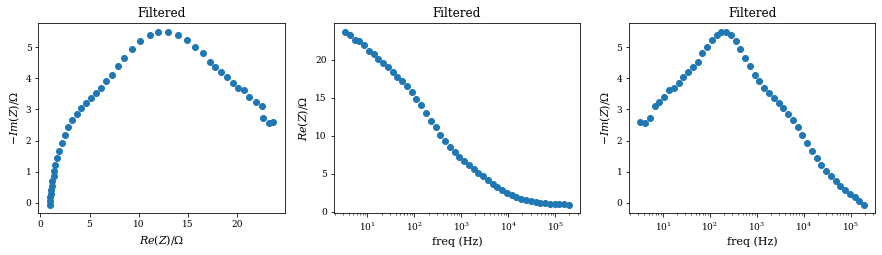

In [21]:
test_name = '1-MEA#3_10_PEIS_C01'
EIS_Clean(root_path,test_name)

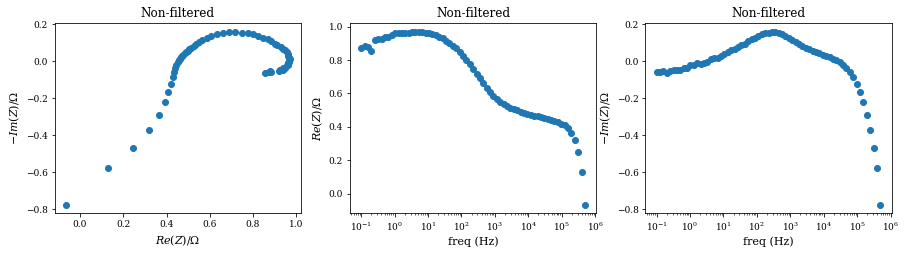

10 0.7572075022751673 0.0068845508588338275
20 0.634858056238381 0.006685200708790584


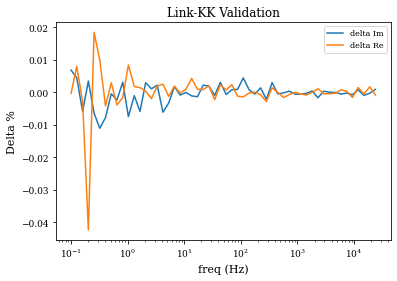

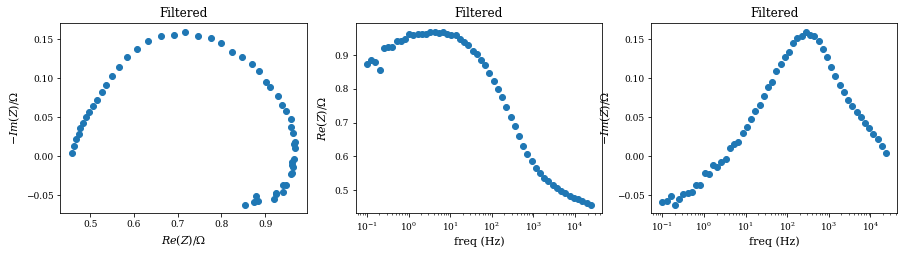

In [25]:
test_name = '1-MEA#3_14_PEIS_C01'
EIS_Clean(root_path,test_name)